定义好模型结构之后，我们要通过以下几个步骤进行模型训练。
1.  网络正向传播计算网络输出和损失函数。
2.  根据损失函数进行反向误差传播，将网络误差从输出层依次向前传递, 并更新网络中的参数。
3.  重复1~2步骤，直至网络训练误差达到规定的程度或训练轮次达到设定值。


导入需要的包
nump:  python第三方库，用于进行科学计算
PIL : Python Image Library,python,python第三方图像处理库
matplotlib:python的绘图库   pyplot:matplotlib的绘图框架
os:提供了丰富的方法来处理文件和目录

In [1]:
#导入需要的包
import numpy as np
import paddle as paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
import os

<h2>STEP1:准备数据</h2>

1.MINIST数据集包含60000个训练集和10000测试数据集。分为图片和标签，图片是28*28的像素矩阵，标签为0~9共10个数字。
2.定义读取MNIST数据集的train_reader和test_reader，指定一个Batch的大小为128，也就是一次训练或验证128张图像。
3.paddle.dataset.mnist.train()或test()接口已经为我们对图片进行了灰度处理、归一化、居中处理等处理。

In [20]:
train_reader = paddle.batch(paddle.reader.shuffle(paddle.dataset.mnist.train(),
                                                  buf_size=512),
                    batch_size=128)
test_reader = paddle.batch(paddle.dataset.mnist.test(),
                           batch_size=128)

尝试打印一下，观察一下minist数据集

In [3]:
temp_reader = paddle.batch(paddle.dataset.mnist.train(),
                           batch_size=1)
temp_data=next(temp_reader())
print(temp_data)

[(array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.

<h2>STEP2:配置网络</h2>

以下的代码判断就是定义一个简单的多层感知器，一共有三层，两个大小为100的隐层和一个大小为10的输出层，因为MNIST数据集是手写0到9的灰度图像，类别有10个，所以最后的输出大小是10。最后输出层的激活函数是Softmax，所以最后的输出层相当于一个分类器。加上一个输入层的话，多层感知器的结构是：输入层-->>隐层-->>隐层-->>输出层。


In [4]:
# 定义多层感知器
def multilayer_perceptron(input):
    # 第一个全连接层，激活函数为ReLU
    hidden1 = fluid.layers.fc(input=input, size=100, act='relu')
    # 第二个全连接层，激活函数为ReLU
    hidden2 = fluid.layers.fc(input=hidden1, size=100, act='relu')
    # 以softmax为激活函数的全连接输出层，大小为10
    prediction = fluid.layers.fc(input=hidden2, size=10, act='softmax')
    return prediction

定义输入层，输入的是图像数据。图像是28*28的灰度图，所以输入的形状是[1, 28, 28]，如果图像是32*32的彩色图，那么输入的形状是[3. 32, 32]，因为灰度图只有一个通道，而彩色图有RGB三个通道。

In [5]:
# 定义输入输出层
image = fluid.layers.data(name='image', shape=[1, 28, 28], dtype='float32')  #单通道，28*28像素值
label = fluid.layers.data(name='label', shape=[1], dtype='int64')            #图片标签

在这里调用定义好的网络来获取分类器

In [6]:
# 获取分类器
model = multilayer_perceptron(image)

接着是定义损失函数，这次使用的是交叉熵损失函数，该函数在分类任务上比较常用。定义了一个损失函数之后，还有对它求平均值，因为定义的是一个Batch的损失值。同时我们还可以定义一个准确率函数，这个可以在我们训练的时候输出分类的准确率。

In [7]:
# 获取损失函数和准确率函数
cost = fluid.layers.cross_entropy(input=model, label=label)  #使用交叉熵损失函数,描述真实样本标签和预测概率之间的差值
avg_cost = fluid.layers.mean(cost)
acc = fluid.layers.accuracy(input=model, label=label)

接着是定义优化方法，这次我们使用的是Adam优化方法，同时指定学习率为0.001。

In [8]:
# 定义优化方法
optimizer = fluid.optimizer.AdamOptimizer(learning_rate=0.001)   #使用Adam算法进行优化
opts = optimizer.minimize(avg_cost)

<h2>STEP3:模型训练 & STEP4:模型评估</h2>

接着也是定义一个解析器和初始化参数，

In [9]:
# 定义一个使用CPU的解析器
place = fluid.CPUPlace()
exe = fluid.Executor(place)
# 进行参数初始化
exe.run(fluid.default_startup_program())

[]

输入的数据维度是图像数据和图像对应的标签，每个类别的图像都要对应一个标签，这个标签是从0递增的整型数值。

In [10]:
# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[image, label])

最后就可以开始训练了，我们这次训练5个Pass。在上面我们已经定义了一个求准确率的函数，所以我们在训练的时候让它输出当前的准确率，计算准确率的原理很简单，就是把训练是预测的结果和真实的值比较，求出准确率。每一个Pass训练结束之后，再进行一次测试，使用测试集进行测试，并求出当前的Cost和准确率的平均值。

In [11]:
# 开始训练和测试
for pass_id in range(5):
    # 进行训练
    for batch_id, data in enumerate(train_reader()):                        #遍历train_reader
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),#运行主程序
                                        feed=feeder.feed(data),             #给模型喂入数据
                                        fetch_list=[avg_cost, acc])         #fetch 误差、准确率
        # 每100个batch打印一次信息  误差、准确率
        if batch_id % 100 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f, Accuracy:%0.5f' %
                  (pass_id, batch_id, train_cost[0], train_acc[0]))

    # 进行测试
    test_accs = []
    test_costs = []
    #每训练一轮 进行一次测试
    for batch_id, data in enumerate(test_reader()):                         #遍历test_reader
        test_cost, test_acc = exe.run(program=fluid.default_main_program(), #执行训练程序
                                      feed=feeder.feed(data),               #喂入数据
                                      fetch_list=[avg_cost, acc])           #fetch 误差、准确率
        test_accs.append(test_acc[0])                                       #每个batch的准确率
        test_costs.append(test_cost[0])                                     #每个batch的误差
    # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))                         #每轮的平均误差
    test_acc = (sum(test_accs) / len(test_accs))                            #每轮的平均准确率
    print('Test:%d, Cost:%0.5f, Accuracy:%0.5f' % (pass_id, test_cost, test_acc))
    
    #保存模型
    model_save_dir = "/home/aistudio/data/hand.inference.model"
    # 如果保存路径不存在就创建
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    print ('save models to %s' % (model_save_dir))
    fluid.io.save_inference_model(model_save_dir,  #保存推理model的路径
                                  ['image'],      #推理（inference）需要 feed 的数据
                                  [model],        #保存推理（inference）结果的 Variables
                                  exe)            #executor 保存 inference model

Pass:0, Batch:0, Cost:2.84289, Accuracy:0.07812
Pass:0, Batch:100, Cost:0.41671, Accuracy:0.86719
Pass:0, Batch:200, Cost:0.33633, Accuracy:0.89062
Pass:0, Batch:300, Cost:0.45717, Accuracy:0.87500
Pass:0, Batch:400, Cost:0.30301, Accuracy:0.90625
Test:0, Cost:0.23811, Accuracy:0.92652
save models to /home/aistudio/data/hand.inference.model
Pass:1, Batch:0, Cost:0.16062, Accuracy:0.93750
Pass:1, Batch:100, Cost:0.24389, Accuracy:0.91406
Pass:1, Batch:200, Cost:0.16197, Accuracy:0.95312
Pass:1, Batch:300, Cost:0.13159, Accuracy:0.94531
Pass:1, Batch:400, Cost:0.09942, Accuracy:0.96875
Test:1, Cost:0.15261, Accuracy:0.95283
save models to /home/aistudio/data/hand.inference.model
Pass:2, Batch:0, Cost:0.34116, Accuracy:0.91406
Pass:2, Batch:100, Cost:0.12896, Accuracy:0.94531
Pass:2, Batch:200, Cost:0.11221, Accuracy:0.96875
Pass:2, Batch:300, Cost:0.21040, Accuracy:0.92969
Pass:2, Batch:400, Cost:0.08679, Accuracy:0.96875
Test:2, Cost:0.12282, Accuracy:0.96064
save models to /home/aistud

<h2>STEP5:模型预测</h2>

在预测之前，要对图像进行预处理，处理方式要跟训练的时候一样。首先进行灰度化，然后压缩图像大小为28*28，接着将图像转换成一维向量，最后再对一维向量进行归一化处理。

In [12]:
# 对图片进行预处理
def load_image(file):
    im = Image.open(file).convert('L')                        #将RGB转化为灰度图像，L代表灰度图像，灰度图像的像素值在0~255之间
    im = im.resize((28, 28), Image.ANTIALIAS)                 #resize image with high-quality 图像大小为28*28
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)#返回新形状的数组,把它变成一个 numpy 数组以匹配数据馈送格式。
   # print(im)
    im = im / 255.0 * 2.0 - 1.0                               #归一化到【-1~1】之间
    print(im)
    return im

我们可以使用Matplotlib工具显示这张图像。

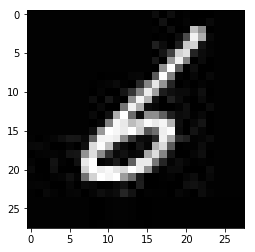

In [13]:
# img = Image.open('/home/aistudio/data/data1906/infer_3.png')
#img = Image.open('/home/aistudio/data/data2304/infer_3.png')
img = Image.open('/home/aistudio/data/data2670/6.jpg')
plt.imshow(img)   #根据数组绘制图像
plt.show()        #显示图像

In [14]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

最后把图像转换成一维向量并进行预测，数据从feed中的image传入。fetch_list的值是网络模型的最后一层分类器，所以输出的结果是10个标签的概率值，这些概率值的总和为1。

In [15]:
# 加载数据并开始预测
with fluid.scope_guard(inference_scope):
    #获取训练好的模型
    #从指定目录中加载 推理model(inference model)
    [inference_program,                                           #推理Program
     feed_target_names,                                           #是一个str列表，它包含需要在推理 Program 中提供数据的变量的名称。 
     fetch_targets] = fluid.io.load_inference_model(model_save_dir,#fetch_targets：是一个 Variable 列表，从中我们可以得到推断结果。model_save_dir：模型保存的路径
                                                    infer_exe)     #infer_exe: 运行 inference model的 executor
   # img = load_image('/home/aistudio/data/data2304/infer_3.png')
    img = load_image('/home/aistudio/data/data2670/6.jpg')

    results = exe.run(program=inference_program,     #运行推测程序
                   feed={feed_target_names[0]: img}, #喂入要预测的img
                   fetch_list=fetch_targets)         #得到推测结果,    
                  
   

[[[[-0.9843137  -0.9843137  -0.9843137  -0.9843137  -0.9843137
    -0.9843137  -0.9843137  -0.9843137  -0.9843137  -0.9843137
    -0.9843137  -0.9843137  -0.9843137  -0.9843137  -0.9843137
    -0.9843137  -0.90588236 -1.         -0.8980392  -0.99215686
    -0.9764706  -1.         -1.         -1.         -0.9843137
    -0.9843137  -0.9843137  -0.9843137 ]
   [-0.9843137  -0.9843137  -0.9843137  -0.9843137  -0.9843137
    -0.9843137  -0.9843137  -0.9843137  -0.9843137  -0.9843137
    -0.9843137  -0.9843137  -0.9843137  -0.9843137  -0.9843137
    -0.9843137  -1.         -0.8666667  -1.         -0.99215686
    -0.9607843  -1.         -0.99215686 -0.92941177 -0.9843137
    -0.9843137  -0.9843137  -0.9843137 ]
   [-0.9843137  -0.9843137  -0.9843137  -0.9843137  -0.9843137
    -0.9843137  -0.9843137  -0.9843137  -0.9843137  -0.9843137
    -0.9843137  -0.9843137  -0.9843137  -0.9843137  -0.9843137
    -0.9843137  -0.96862745 -1.         -0.8980392  -1.
    -0.9843137   0.5058824   0.09803927 -

拿到每个标签的概率值之后，我们要获取概率最大的标签，并打印出来。

In [16]:
# 获取概率最大的label
lab = np.argsort(results)                               #argsort函数返回的是result数组值从小到大的索引值
#print(lab)
print("该图片的预测结果的label为: %d" % lab[0][0][-1])  #-1代表读取数组中倒数第一列  

该图片的预测结果的label为: 6
